# Image Segmentation

1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing
3. Build model
4. Train model
5. Evaluate model
6. Repeat

## Project Description

### Task
* Polyp segmentation from colonoscopy image by using GIANA dataset
* This code is borrowed from [TensorFlow tutorials/Image Segmentation](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) which is made of `tf.keras.layers`.
* You can see the detail description [tutorial link](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)  

### Dataset
* [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (345MB)
  * Train data: 300 images with RGB channels (bmp format)
  * Train lables: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Resize **image size to 256** when training

### Baseline code
* Input data shape: (`batch_size`, 256, 256, 3)
* Output data shape: (`batch_size`, 256, 256, 1)
* Architecture: 
  * Encoder-Decoder
* Training
* Evaluation
  * MeanIOU
  * tf.version 2.0 API: [`tf.keras.metrics.MeanIoU`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics/MeanIoU)

## Import modules

### Import colab modules for Google Colab (if necessary)

In [ ]:
!pip install tensorflow-gpu==2.1

In [ ]:
use_colab = True
assert use_colab in [True, False]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import base modules

In [ ]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.1.0


# Model Selection
* Will only use encoder-decoder model in this file

In [ ]:
is_train = True

model_name = 'ed_model'
assert model_name in ['ed_model', 'u-net']

## Data collection and Visualization

### Download data

This project will use [Giana Dataset](https://giana.grand-challenge.org/Dates/).

In [ ]:
if use_colab:
    DATASET_PATH='./drive/My Drive/datasets/'
else:
    DATASET_PATH='../../datasets/'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

    import urllib.request
    u = urllib.request.urlopen(url='http://bigfile.mail.naver.com/bigfileupload/download?fid=8enZaAIq1NKXFqMjK3YXaxKZFCYZKAUmKxgZKxUmKqUqFCYwFog9aA2dKqvlHqKqK6KmK4kvFAFopxIvF6t9Kqg9KoEZM6pvFAkoFrt/')
    data = u.read()
    u.close()

    with open('sd_train.zip', "wb") as f :
        f.write(data)
        print('Data has been downloaded')

    shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
    file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

    import zipfile
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(DATASET_PATH)
    zip_ref.close()
    print('Data has been extracted.')
    
else:
    print('Data has already been downloaded and extracted.')

Data has already been downloaded and extracted.


### Split dataset into train data and test data

In [ ]:
dataset_dir = os.path.join(DATASET_PATH, 'sd_train') 

img_dir = os.path.join(dataset_dir, "train") 
label_dir = os.path.join(dataset_dir, "train_labels")

In [ ]:
print(dataset_dir)
print(img_dir)
print(label_dir)

./drive/My Drive/datasets/sd_train
./drive/My Drive/datasets/sd_train/train
./drive/My Drive/datasets/sd_train/train_labels


In [ ]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [ ]:
print(len(x_train_filenames))
print(len(y_train_filenames))

600
600


In [ ]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [ ]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


### Visualize

Pick 5 images from dataset.

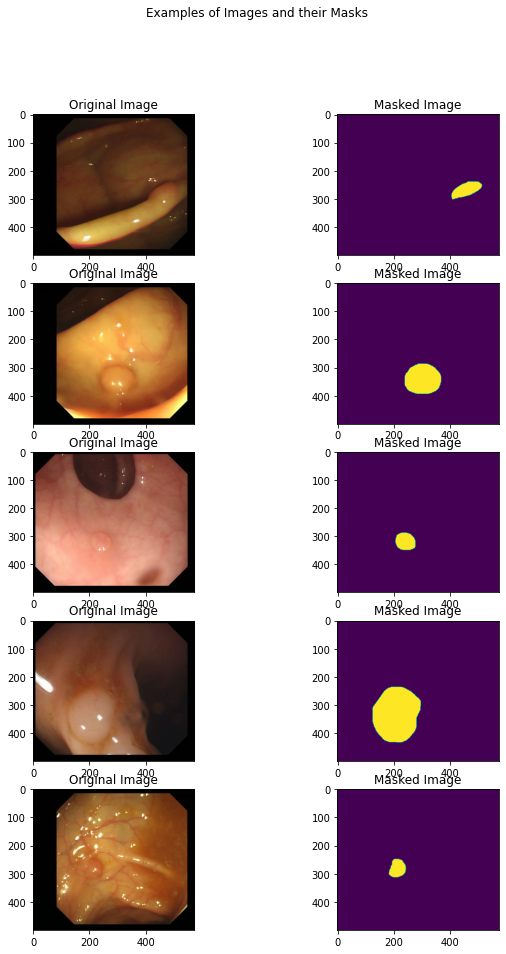

In [ ]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and preprocessing

### Set up hyper-parameters



In [ ]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 32 
max_epochs = 150

if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = './train_ckpt/segmentation/exp1'

### Build our input pipeline with `tf.data`

> 1. Read the bytes from file name. 
> 2. Decode the bytes to image type
> 3. Apply image transformations : 
> * `resize`
> * `hue_delta`
> * `horizontal_flip`
> * `width_shift_range`, `height_shift_range`
> * `rescale`
> 4. Mix the data, repeat the training.

#### Why do we do these image transformations?

> This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

#### Processing each pathname

In [ ]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255. # 0~255 normalize => 0~1
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### Shifting the image

In [ ]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### Flipping the image randomly

In [ ]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### Assembling our transformations into our augment function

In [ ]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.05,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [ ]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels)) 
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

### Set up train and test datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [ ]:
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()

test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)

In [ ]:
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

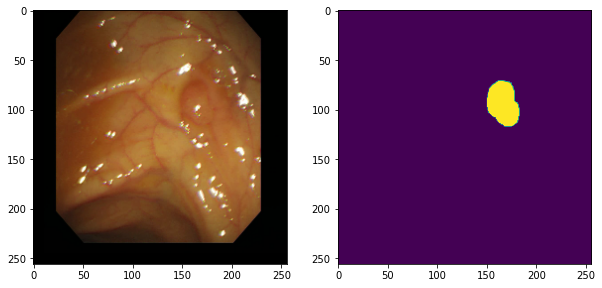

In [ ]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show() 

## Build the model

Will only make Encoder-Decoder model in this file.

### Encoder-Decoder architecture

#### Encoder
* `input data` shape:
  * inputs = [batch_size, 256, 256, 3]
  * conv1 => [batch_size, 128, 128, 32]
  * conv2 => [batch_size, 64, 64, 64]
  * conv3 => [batch_size, 32, 32, 128]
  * outputs => [batch_size, 16, 16, 256]
* Convolution - Normalization - Activation - Pooling
* `tf.keras.Sequential()`
  
#### Decoder
* Mirror of Encoder
* `input data` shape:
  * inputs = outputs of encoder = [batch_size, 16, 16, 256]
  * conv_transpose1 => [batch_size, 32, 32, 128]
  * conv_transpose2 => [batch_size, 64, 64, 64]
  * conv_transpose3 => [batch_size, 128, 128, 32]
  * outputs = [batch_size, 256, 256, 1]
* `tf.keras.Sequential()`

In [ ]:
model=tf.keras.Sequential(name='test')
model.add(layers.Conv2D(1, 2, input_shape=[4,4,1], padding='same'))
model.add(layers.Conv2DTranspose(1, 2, padding='same'))

In [ ]:
pred = model(tf.random.normal([1,4,4,1]))
print(pred.shape)
model.summary()

(1, 4, 4, 1)
Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 1)           5         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 1)           5         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if model_name == 'ed_model':
    encoder = tf.keras.Sequential(name='encoder')

In [ ]:
if model_name == 'ed_model':
    # inputs: [batch_size, 256, 256, 3]
    # conv-batchnorm-activation-maxpool
    encoder.add(tf.keras.layers.Conv2D(32, 3, strides=1, padding='same'))
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.Conv2D(32, 3, strides=1, padding='same')) # conv1: [batch_size, 128, 128, 32]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.MaxPool2D())
    encoder.add(tf.keras.layers.Dropout(0.3))

    encoder.add(tf.keras.layers.Conv2D(64, 3, strides=1, padding='same')) 
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.Conv2D(64, 3, strides=1, padding='same')) # conv2: [batch_size, 64, 64, 64]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.MaxPool2D())

    encoder.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same')) 
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same')) # conv3: [batch_size, 32, 32, 128]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.MaxPool2D())
    encoder.add(tf.keras.layers.Dropout(0.3))

    encoder.add(tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')) 
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')) # conv4: [batch_size, 16, 16, 256]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.MaxPool2D())   

    encoder.add(tf.keras.layers.Conv2D(512, 3, strides=1, padding='same'))
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.Conv2D(512, 3, strides=1, padding='same')) # conv5-outputs: [batch_size, 8, 8, 512]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))
    encoder.add(tf.keras.layers.MaxPool2D())   

In [ ]:
if model_name == 'ed_model':
    bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
    print(bottleneck.shape)

(32, 8, 8, 512)


In [ ]:
if model_name == 'ed_model':
    decoder = tf.keras.Sequential(name='decoder')

In [ ]:
if model_name == 'ed_model':
    # inputs: [batch_size, 16, 16, 256]
    # conv_transpose-batchnorm-activation
    decoder.add(tf.keras.layers.Conv2D(512, 3, strides=1, padding='same'))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')) # conv_transpose1: [batch_size, 16, 16, 256]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))

    decoder.add(tf.keras.layers.Conv2D(256, 3, strides=1, padding='same'))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')) # conv_transpose2: [batch_size, 32, 32, 128]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))

    decoder.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same'))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')) # conv_transpose3: [batch_size, 64, 64, 64]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))

    decoder.add(tf.keras.layers.Conv2D(64, 3, strides=1, padding='same')) # conv1: [batch_size, 128, 128, 32]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')) # conv_transpose4: [batch_size, 128, 128, 32]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))

    decoder.add(tf.keras.layers.Conv2D(32, 3, strides=1, padding='same'))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Dropout(0.3))
    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'))
    decoder.add(layers.Activation('sigmoid')) # conv transpose5-outputs: [batch_size, 256, 256, 1]

In [ ]:
if model_name == 'ed_model':
    predictions = decoder(bottleneck)
    print(predictions.shape)

(32, 256, 256, 1)


#### Create a encoder-decocer model

In [ ]:
if model_name == 'ed_model':
    ed_model = tf.keras.Sequential()
    ed_model.add(encoder)
    ed_model.add(decoder)

### Defining custom metrics and loss functions

[Dice coefficient](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$
$p_i$ : predicted binary segmentation volume, $g_i$ : ground truth binary volume

About dice loss

>Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

>Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced.

>We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()

### Select a model

In [ ]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = ed_model

if model_name == 'u-net':
    print('select the U-Net model')
    model = unet_model

select the Encoder-Decoder model


### Compile

In [ ]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]), training=False)
print(predictions.shape)

(32, 256, 256, 1)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         multiple                  4720160   
_________________________________________________________________
decoder (Sequential)         multiple                  4717025   
Total params: 9,437,185
Trainable params: 9,430,273
Non-trainable params: 6,912
_________________________________________________________________


###Model callbacks

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
cos_decay = tf.keras.experimental.CosineDecay(0.0001, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## Train your model

In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training - `model.fit()`

In [ ]:
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback]
                    )

Train for 15 steps, validate for 3 steps
Epoch 1/150
14/15 [===========================>..] - ETA: 1s - loss: 1.4082 - dice_loss: 0.8173
Epoch 00001: val_loss improved from inf to 1.50451, saving model to ./drive/My Drive/train_ckpt/segmentation/exp1
15/15 [==============================] - 36s 2s/step - loss: 1.3992 - dice_loss: 0.8139 - val_loss: 1.5045 - val_dice_loss: 0.8298
Epoch 2/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1842 - dice_loss: 0.7491
Epoch 00002: val_loss improved from 1.50451 to 1.41092, saving model to ./drive/My Drive/train_ckpt/segmentation/exp1
15/15 [==============================] - 11s 715ms/step - loss: 1.1770 - dice_loss: 0.7466 - val_loss: 1.4109 - val_dice_loss: 0.8190
Epoch 3/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9812 - dice_loss: 0.6562
Epoch 00003: val_loss improved from 1.41092 to 1.26654, saving model to ./drive/My Drive/train_ckpt/segmentation/exp1
15/15 [==============================] - 11s 740ms/step 

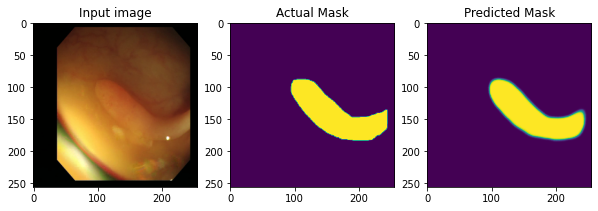

In [ ]:
# print sample image after training
print_images()

### Plot the loss

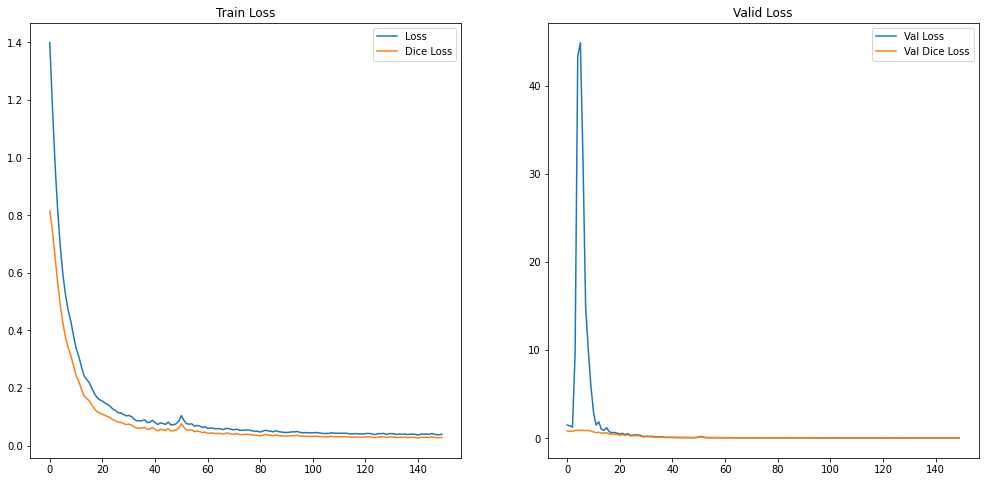

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

## Restore the latest checkpoint

In [ ]:
if not is_train:
    # restoring the latest checkpoint in checkpoint_dir
    model.load_weights(checkpoint_dir)

## Evaluate the test dataset

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [ ]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9535477096018539
